## Q2, QDA ##

In [1]:
import numpy as np
import random
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

In [335]:
def generate_n_i_range(K, n):
    cuts = np.zeros(K-1)
    for i in range(K-1):
        cuts[i] = random.randrange(0, n)
    n_i_range = np.sort(cuts)
    n_i_range = np.append(n_i_range,n)
    for i in range(K-1,0, -1):
        n_i_range[i] = int(n_i_range[i] - n_i_range[i-1])
    n_i_range = [int(x) for x in n_i_range]
    return n_i_range

def generate_data(K,p,n,mu_interval,cov_interval):
    sigma = np.random.random((K, p, p))*(cov_interval[1] - cov_interval[0])+cov_interval[0]
    for i in range(K):
        sigma_i = sigma[i]
        sigma[i] = np.dot(sigma_i,sigma_i.transpose())

    mu = np.random.random((K,p))*(mu_interval[1] - mu_interval[0]) + mu_interval[0]
    n_i_range = generate_n_i_range(K,n)
    pi = [x/n for x in n_i_range]
    
    x = np.zeros((n,p))

    for i in range(K):
        mu_i = mu[i,:]
        sigma_i = sigma[i,:,:]
        rv = multivariate_normal(mean = mu_i, cov = sigma_i)
        start_index = sum(n_i_range[:i])
        stop_index = sum(n_i_range[:i+1])
        generated_data = np.array(rv.rvs(size = n_i_range[i]))
        x[start_index:stop_index] = generated_data

    y_temp = np.zeros((n,K))
    
    for i in range(K):
        mu_i = mu[i,:]
        sigma_i = sigma[i,:,:]
        rv = multivariate_normal.pdf(x, mean = mu_i, cov = sigma_i)*pi[i]
        y_temp[:,i] = rv

    y = np.argmax(y_temp, 1)
    return x, y, pi, sigma, mu

def estimate(x,y):
    K = np.max(y) + 1
    n = x.shape[0]
    p = x.shape[1]

    pihat = np.zeros(K)
    muhat = np.zeros((K,p))
    sigmahat = np.zeros((K,p,p))
    for i in range(K):
        data_class = x[np.argwhere(y==i).reshape(-1), :]
        n_i = data_class.shape[0]
        
        pihat[i] = n_i/n
        
        muhat_i = 1/n_i*np.sum(data_class,0)
        muhat[i] = muhat_i 
        
        sigmahat_i = 1/(n_i-1)*np.dot((data_class - muhat_i).transpose(), data_class - muhat_i)
        sigmahat[i] = sigmahat_i
    return pihat,sigmahat,muhat
    

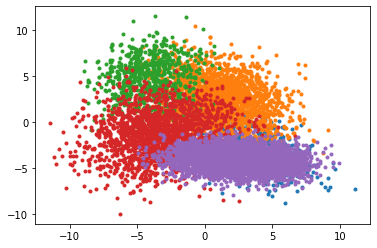

In [336]:
K = 5
p = 4
n = 10000
mu_interval = [-5, 5]
cov_interval = [-2, 2]

x,y,pi,sigma,mu = generate_data(K,p,n,mu_interval,cov_interval)
for i in range(K):
    plt.plot(x[y==i, 0], x[y==i, 1], '.')
    
pihat,sigmahat,muhat = estimate(x,y)


(500,)


## Q2, CART ##

In [2]:
import numpy as np
import random
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

In [3]:
def generate_pi_range(K, n):
    cuts = np.zeros(K-1)
    for i in range(K-1):
        cuts[i] = random.randrange(0, n)
    pi_range = np.sort(cuts)
    pi_range = np.append(pi_range,n)
    for i in range(K-1,0, -1):
        pi_range[i] = int(pi_range[i] - pi_range[i-1])
    pi_range = [int(x) for x in pi_range]
    return pi_range

In [4]:
def split(limits):
    p = limits.shape[0]
    feat = int(random.randrange(0,p))
    place = np.random.random(1)*(limits[feat,0] - limits[feat,1])+ limits[feat,1]
    
    new_limits_high = np.copy(limits)
    new_limits_high[feat,0] = place
    
    new_limits_low = np.copy(limits)
    new_limits_low[feat,1] = place
    
    size_low = 1
    size_high = 1
    for i in range(p):
        size_low = size_low*(new_limits_low[i,1] - new_limits_low[i,0])
        size_high = size_high*(new_limits_high[i,1] - new_limits_high[i,0])
    
    return new_limits_low, new_limits_high, feat, place, size_low, size_high

In [11]:
def generate_data_CART(K ,p ,n ,nr_splits ,intervals):
    
    splits = np.zeros((nr_splits,2))
    all_limits = np.zeros((nr_splits + 1, p, 2))
    all_limits[0,:,:] = intervals
    sizes = np.zeros(nr_splits + 1)

    pointer = 1
    for i in range(nr_splits):
        j = int(random.randrange(0,pointer))
        base = all_limits[j,:,:]

        new_limits_low, new_limits_high, feat, place, size_low, size_high = split(base)
        splits[i,0] = place
        splits[i,1] = feat


        all_limits[j,:,:] = new_limits_low
        sizes[j] = size_low

        all_limits[pointer,:,:] = new_limits_high
        sizes[pointer] = size_high
        pointer += 1

        
    split_ranges = np.ones(nr_splits + 1) * (n / (nr_splits+1))
    split_ranges = np.multiply(split_ranges, sizes)
    split_ranges = split_ranges * (n/sum(split_ranges))
    

    data = np.zeros((n,p))
    classes = np.zeros((n,1))

    data_pointer = 0
    for k in range(nr_splits + 1):
        c = int(random.randrange(0,K))

        for i in range(int(split_ranges[k])+1):
            pnt = np.random.random(p)*(all_limits[k,:,0] - all_limits[k,:,1])+ all_limits[k,:,1]
            data[data_pointer + i,:] = pnt
            classes[data_pointer + i] = c

        data_pointer += int(split_ranges[k])

    return data, classes, splits

In [12]:
def plot_CART(p, data, classes):
    if(p == 2):
        """
        for i in range(nr_splits):
            if(int(splits[i,1]) == 0):
                splitlines = [np.ones(n)*splits[i][0], np.linspace(interval[0], interval[1], n)]
            else:
                splitlines = [np.linspace(interval[0], interval[1], n), np.ones(n)*splits[i][0]]

            plt.plot(splitlines[0], splitlines[1], color = 'black')
        """



        for i in range(K+1):
            indexes = np.argwhere(classes == i)[:,0]
            plt.plot(data[indexes,0], data[indexes,1],'.') 


        plt.xlim(interval)
        plt.ylim(interval)

    else:
        print("## NOTE: no plot since there are more than 2 features ##")

## Training ##

In [13]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

In [18]:
K = 3
p = 2
n = 100000
nr_splits = 10
interval = [-7.0, 7.0]
intervals = np.array([interval for i in range(p)])

x_CART, y_CART, splits = generate_data_CART(K ,p ,n ,nr_splits ,intervals)

print(f'K = {K}')
print(f'p = {p}')
print(f'n = {n}')
print(f'number of splits = {nr_splits}')

#plot_CART(p, data, classes)

x_CART_train, x_CART_test, y_CART_train, y_CART_test = train_test_split(x_CART, y_CART, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier()
clf = clf.fit(x_CART_train,y_CART_train)

y_CART_pred = clf.predict(x_CART_test)


print("Accuracy:",metrics.accuracy_score(y_CART_test, y_CART_pred))

K = 3
p = 2
n = 100000
number of splits = 10
Accuracy: 0.9999
